# [Computational Social Science] Project 4: Unsupervised Learning

**Enter your Name:** Stacy

*Semester:* Fall 2023

## Data Description and Preprocessing

For this project, you will explore data from the [National Health and Nutrition Examination Survey](https://www.kaggle.com/cdc/national-health-and-nutrition-examination-survey?select=questionnaire.csv). NHANES is a unique study that combines survey methodology with in-person medical examinations to create a dataset with demographic information, health indicators, and health outcomes.

We start by importing the data and doing some preliminary preprocessing for you. We import some libraries that will be helpful as well. 'SEQN' is the ID number for each respondent, and 'HSD010' will be our target outcome. [HSD010](https://wwwn.cdc.gov/Nchs/Nhanes/2013-2014/HSQ_H.htm#HSD010) asks for the respondent's self reported health condition, which can range from "excellent" to "poor."

In [2]:
# Import libraries
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import Dense, Dropout
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.model_selection import train_test_split
sns.set_style("darkgrid")
from sklearn.model_selection import train_test_split

2023-12-13 18:50:36.235712: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-13 18:50:36.369862: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-12-13 18:50:36.374142: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-12-13 18:50:36.374161: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore 

In [3]:
# Load nhanes data
nhanes = pd.read_csv('nhanes.csv')
# Get the ID numbers for each observation (seqn)
seqn = nhanes['SEQN']
# Get the target, "self-reported health condition," HSD010
hsd010 = nhanes['HSD010']
# Drop SEQN from the dataframe and then apply the standard scaler
nhanes = nhanes.drop(['SEQN', 'HSD010'], axis = 1)
nhanes_scaled = pd.DataFrame(StandardScaler().fit_transform(nhanes),
                             columns = nhanes.columns)
# Add the ID and target back in
nhanes_scaled['SEQN'] = seqn
nhanes_scaled['HSD010'] = hsd010
nhanes_scaled = nhanes_scaled.set_index('SEQN')
nhanes_scaled.head()

,DR1DRSTZ,DR1EXMER,DRABF,DRDINT,DR1DBIH,DR1DAY,DR1LANG,DR1MNRSP,DR1HELPD,DBQ095Z,...,OHQ770,OHQ845,PAAQUEX,SMQ860,SMQ870,SMQ872,SMQ874,SMQ878,SMAQUEX.x,HSD010
SEQN,,,,,,,,,,,,,,,,,,,,,
73568,0.0,2.034312,0.0,0.324834,-0.393906,1.085853,-0.194202,-0.057306,0.128246,-0.189513,...,0.383802,-0.646584,-0.484200,1.125008,0.0,-2.081666,1.087115,1.463404,0.612440,1
73576,0.0,0.261930,0.0,-3.078499,0.568251,0.634362,-0.194202,-0.057306,0.128246,0.080373,...,0.383802,-1.539259,-0.484200,1.125008,0.0,-2.081666,1.087115,-0.683338,-1.632812,1
73579,0.0,0.728346,0.0,0.324834,1.530407,-1.623092,-0.194202,-0.057306,0.128246,-0.189513,...,0.383802,-1.539259,2.065262,-0.888883,0.0,0.480384,-0.919866,-0.683338,-1.632812,2
73581,0.0,-0.857470,0.0,0.324834,0.480782,1.085853,-0.194202,-0.057306,0.128246,0.080373,...,0.383802,-0.646584,-0.484200,1.125008,0.0,0.480384,-0.919866,-0.683338,0.612440,2
73584,0.0,0.495138,0.0,0.324834,0.305844,-1.623092,-0.194202,-0.057306,0.128246,0.080373,...,-2.605509,0.246091,2.065262,1.125008,0.0,0.480384,-0.919866,1.463404,-1.632812,3


## Plots

Let's take a look at the data. Below we visualize boxplots of family income to federal poverty line ratio ('INDFMPIR') and self-reported health condition. Notice how there are some clear patterns (the lower the ratio, the lower reported health condition), but it's not a perfect separation. We have 240+ features in our dataset, and we likely have several features in our dataset that highly correlate with our family income-poverty line ratio measure - PCA will help us simplify these.

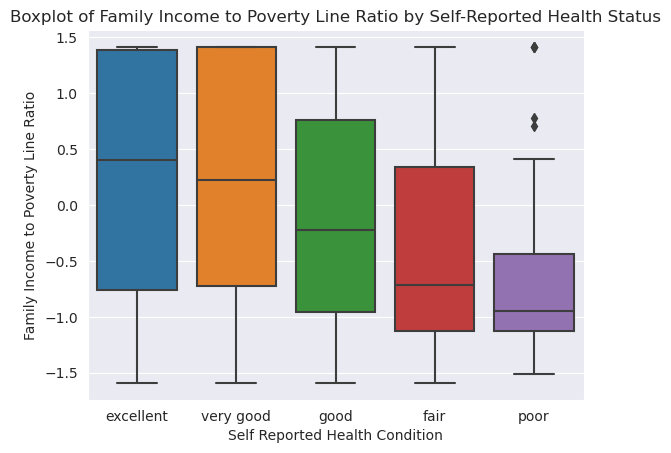

In [4]:
# Create a binary version of hsd010 where 1-3 are "good" and 4-5 are "poor"
nhanes_scaled['HSD010_binary'] = hsd010_binary = nhanes_scaled['HSD010'].replace(
    [1, 2, 3, 4, 5], ['good', 'good', 'good', 'poor', 'poor']) 
# Recode the original hsd010 with the string labels
nhanes_scaled['HSD010'] = nhanes_scaled['HSD010'].replace(
    [1, 2, 3, 4, 5], ['excellent', 'very good', 'good', 'fair', 'poor'])
# Boxplot of hsd010
ax = sns.boxplot(x = 'HSD010', y = 'INDFMPIR', data = nhanes_scaled)
ax.set(xlabel = "Self Reported Health Condition",
      ylabel = "Family Income to Poverty Line Ratio")
ax.set_title("Boxplot of Family Income to Poverty Line Ratio by Self-Reported Health Status")
plt.show()

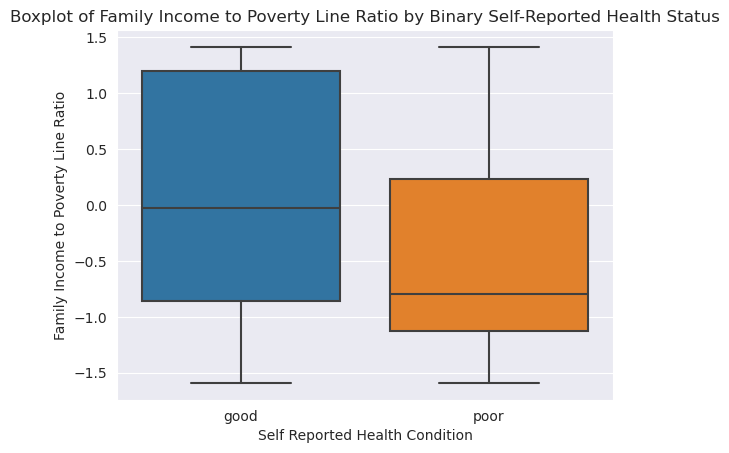

In [5]:
# Boxplot of hsd010_binary
ax = sns.boxplot(x = 'HSD010_binary', y = 'INDFMPIR', data = nhanes_scaled)
ax.set(xlabel = "Self Reported Health Condition",
      ylabel = "Family Income to Poverty Line Ratio")
ax.set_title("Boxplot of Family Income to Poverty Line Ratio by Binary Self-Reported Health Status")
plt.show()

Family income also is not necessarily well correlated with measured health outcomes. See below where we look at the relationship between Body Mass Index (BMI) and the family income-poverty line ratio, and shade points by self-reported health condition. It's hard to find a clear pattern - this is where clustering may come in handy. 

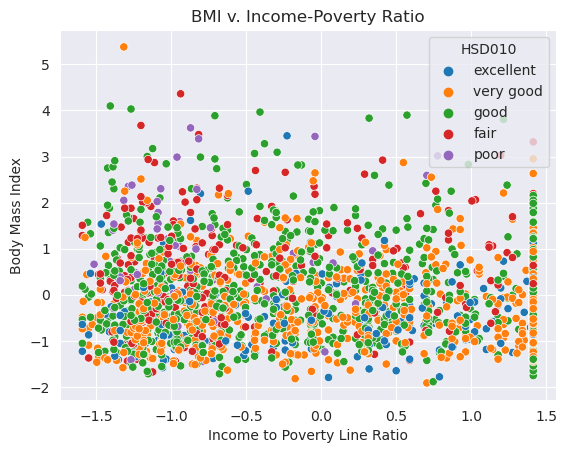

In [6]:
ax = sns.scatterplot(x = "INDFMPIR", y = "BMXBMI", hue = "HSD010", palette = "tab10", data = nhanes_scaled)
ax.set(xlabel = "Income to Poverty Line Ratio",
      ylabel = "Body Mass Index")
ax.set_title("BMI v. Income-Poverty Ratio")
plt.show()

Before we move to working on unsupervised methods, we'll drop our target variables again:

In [7]:
nhanes_scaled = nhanes_scaled.drop(['HSD010', 'HSD010_binary'], axis = 1)

## Principal Component Analysis

Conduct a Principal Component Analysis (PCA) of the nhanes data. The data has already been prepared for you, so you can work directly on nhanes_scaled. Be sure to do the following:

- Choose the number of components and provide 1-2 sentences about your choice of the number of components. 
- Plot a barplot of the variation explained by each component. *Hint*: look at the attributes associated with your model. 
- Choose how many components you will use to fit a supervised learning model and provide 1-2 sentences to explain that choice.
- Plot a 2D scatterplot of the first two components and provide 1-2 sentences analyzing the plot.

### Train PCA and Discuss Number of Components

I chose 3 components since there appears to be a limited amount of variation explained by each component after 3 components (less than 5%). It would also be easier to interpret to limit the number of components. 

In [8]:
from sklearn.decomposition import PCA
pca = PCA(n_components=3)
principalComponents_nhanes_scaled = pca.fit_transform(nhanes_scaled)

In [9]:
pca_df = pd.DataFrame(data = principalComponents_nhanes_scaled
             , columns = ['principal component 1', 'principal component 2', 'principal component 3'])

In [10]:
pca_df.head()

,principal component 1,principal component 2,principal component 3
0,9.527811,-0.816242,-1.866555
1,-5.838339,-3.692579,3.805968
2,-0.719454,-2.573202,0.907948
3,3.533627,-2.576975,-3.249283
4,-6.872094,-4.194238,0.886747


### Barplot of Components

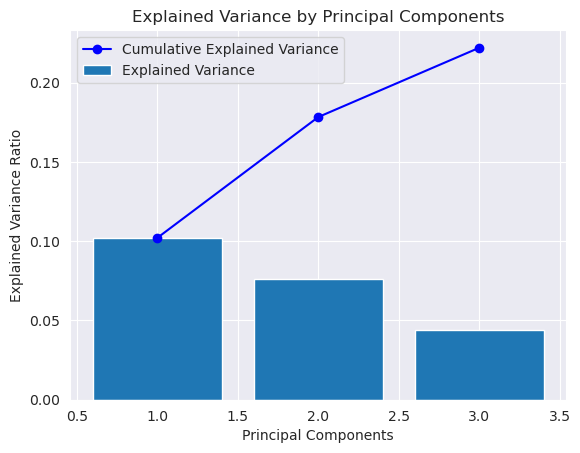

In [11]:
pca = PCA(n_components=3)
principalComponents_nhanes_scaled = pca.fit_transform(nhanes_scaled)

# Calculate the cumulative explained variance
cumulative_explained_variance = np.cumsum(pca.explained_variance_ratio_)

# Barplot of the explained variance for each component
plt.bar(range(1, len(cumulative_explained_variance) + 1), pca.explained_variance_ratio_, label='Explained Variance')
plt.plot(range(1, len(cumulative_explained_variance) + 1), cumulative_explained_variance, label='Cumulative Explained Variance', marker='o', color='blue')

plt.xlabel('Principal Components')
plt.ylabel('Explained Variance Ratio')
plt.title('Explained Variance by Principal Components')
plt.legend()
plt.show()

### How many components will you use to fit a supervised learning model?

In [12]:
#I will use 3 components to fit the supervised learning model since the explained variance will be below 0.05 after the 3rd principal component, it won't be worthwhile. 

### 2D Scatterplot of the first two components

<Figure size 640x480 with 0 Axes>

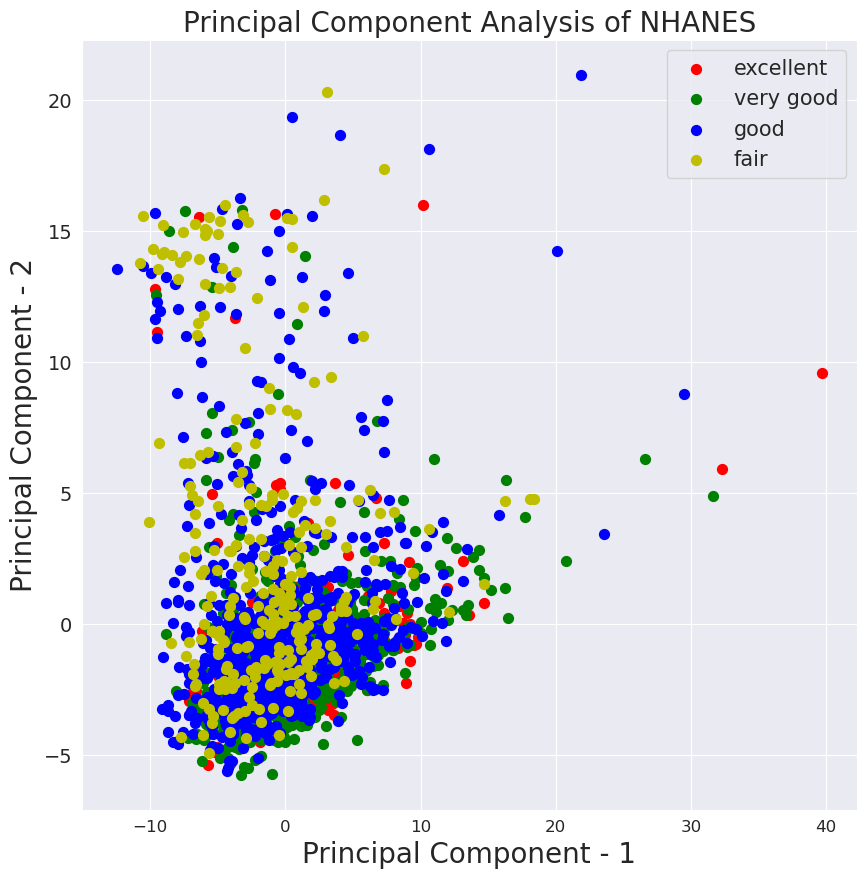

In [13]:
# Load nhanes data
nhanes = pd.read_csv('nhanes.csv')
# Get the ID numbers for each observation (seqn)
seqn = nhanes['SEQN']
# Get the target, "self-reported health condition," HSD010
hsd010 = nhanes['HSD010']
# Drop SEQN from the dataframe and then apply the standard scaler
nhanes = nhanes.drop(['SEQN', 'HSD010'], axis = 1)
nhanes_scaled = pd.DataFrame(StandardScaler().fit_transform(nhanes),
                             columns = nhanes.columns)
# Add the ID and target back in
nhanes_scaled['SEQN'] = seqn
nhanes_scaled['HSD010'] = hsd010
nhanes_scaled = nhanes_scaled.set_index('SEQN')
# figure settings
plt.figure()
plt.figure(figsize=(10,10))
plt.xticks(fontsize=12)
plt.yticks(fontsize=14)
plt.xlabel('Principal Component - 1',fontsize=20)
plt.ylabel('Principal Component - 2',fontsize=20)
plt.title("Principal Component Analysis of NHANES",fontsize=20)
targets = ['excellent', 'very good', 'good', 'fair', 'poor']
colors = ['r', 'g', 'b', 'y']
nhanes_scaled['SEQN'] = seqn
nhanes_scaled['HSD010'] = hsd010
hsd010 = hsd010.replace(
    [1, 2, 3, 4, 5], ['excellent', 'very good', 'good', 'fair', 'poor'])
for target, color in zip(targets,colors):
    indicesToKeep = hsd010 == target
    indicesToKeep = indicesToKeep.reset_index(drop=True) #had to add this line
    plt.scatter(pca_df.loc[indicesToKeep, 'principal component 1']
               , pca_df.loc[indicesToKeep, 'principal component 2'], c = color, s = 50)
# show figure
plt.legend(targets,prop={'size': 15})
plt.show();

In [14]:
#PCA is used to reduce the dimensionality of data, so when analyzing it is it important to look at whether there is variance explained from looking at the plot. I check to see if there's a specific pattern or clusters. It seems like the data are clustered too close together to identify a clear pattern-- this supports my deicision of using 3 components instead of only 2.  

## K-Means

- Choose a clustering algorithm and explain it in 1-2 sentences.
- Cluster the nhanes data. Detail any choice you need to make with regards to number of clusters, and how you arrived at that choice. For instance, you might use the [elbow method](https://en.wikipedia.org/wiki/Elbow_method_(clustering)) if you choose k-means.
- Plot your clusters on top of BMI v. Income Poverty Ratio Plot. Describe what you see in 1-2 sentences.
- Retrain the clustering algorithm, but this time use your PCA results instead of the original dataframe. Plot the clusters on top of the 2D PCA scatterplot from the previous step. Describe your results in 1-2 sentences.

### Choose a Clustering Algorithm

In [15]:
# I will choose kmeans to create clusters: it is a algorithm that can partition data into distinct subsets by grouping similar data points into clusters. It also doesn't required labeled data to train and basically assigns data to cluster with nearest mean.  
##########
#load libraries 
# ----------
from sklearn.cluster import KMeans
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
# Load nhanes data
nhanes = pd.read_csv('nhanes.csv')
# Get the ID numbers for each observation (seqn)
seqn = nhanes['SEQN']
# Get the target, "self-reported health condition," HSD010
hsd010 = nhanes['HSD010']
# Drop SEQN from the dataframe and then apply the standard scaler
nhanes = nhanes.drop(['SEQN', 'HSD010'], axis = 1)
nhanes_scaled = pd.DataFrame(StandardScaler().fit_transform(nhanes),
                             columns = nhanes.columns)
# Add the ID and target back in
nhanes_scaled['SEQN'] = seqn
nhanes_scaled['HSD010'] = hsd010
nhanes_scaled = nhanes_scaled.set_index('SEQN')
#nhanes_scaled.head()

### Cluster nhanes

In [19]:
# settings
%matplotlib inline
np.random.seed(10)
# specify kmeans algorithm
# ----------
kmeans = KMeans(n_clusters=5,
                n_init=10,
                max_iter=300 #default
                ).fit(nhanes_scaled)
# ----------

### Plot your clusters on top of the BMI v. Income Poverty Ratio Plot

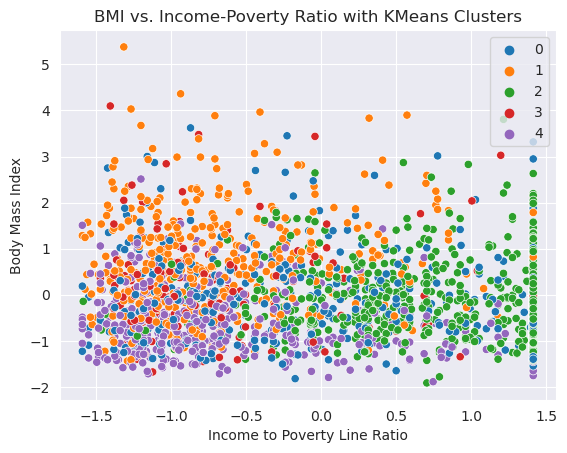

In [20]:
kmeans = KMeans(n_clusters=5, n_init=10, max_iter=300, random_state=42)
labels = kmeans.fit_predict(nhanes_scaled)

# Create a scatter plot for BMI vs. Income-Poverty Ratio
ax = sns.scatterplot(x="INDFMPIR", y="BMXBMI", hue=labels, palette="tab10", data=nhanes_scaled)

# Set axis labels and title
ax.set(xlabel="Income to Poverty Line Ratio", ylabel="Body Mass Index")
ax.set_title("BMI vs. Income-Poverty Ratio with KMeans Clusters")

# Display the plot
plt.show()

## Your Answer Here

### Retrain the clustering algorithm on PCA components and plot clusters on your 2D scatter

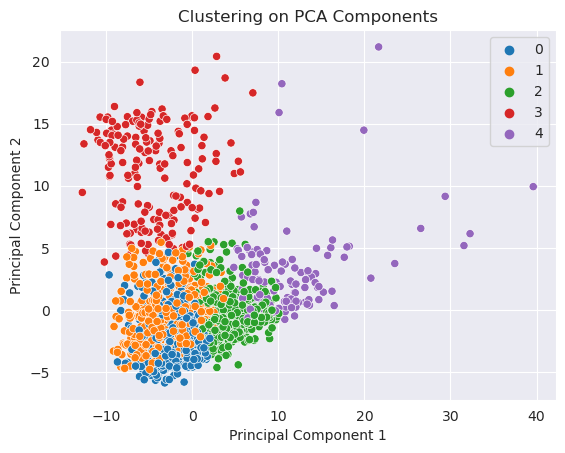

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
# Perform PCA to double check
pca = PCA(n_components=3)
pca_components = pca.fit_transform(nhanes_scaled)

# Retrain KMeans on PCA components
kmeans_pca = KMeans(n_clusters=5, n_init=10, max_iter=300, random_state=42)
labels_pca = kmeans_pca.fit_predict(pca_components)

# Create a scatter plot for the first two principal components
ax = sns.scatterplot(x=pca_components[:, 0], y=pca_components[:, 1], hue=labels_pca, palette="tab10")

# Set axis labels and title
ax.set(xlabel="Principal Component 1", ylabel="Principal Component 2")
ax.set_title("Clustering on PCA Components")

# Display the plot
plt.show()

These clusters are more identifiable plotted on PCA components instead of just BMI vs poverty plot. It makes sense because PCA picks up on the the most important components-- it is an interesting demonstration of how using PCA could be more useful as a tool on top of using domain knowledge. It also demonstrates that Kmeans can create clusters and we need to be mindful about how to visualize them. 

## Neural Network

Now we are ready to predict! Do the following:

- Choose either HSD010 or HSD010\_binary as your target outcome.  
- Train a neural network using the original features. Much of the code to train a basic neural net has been set up for you, but you will need to fill in a couple of missing pieces.
- Train a neural network using only your PCA components as features.
- Train a neural network using your PCA components and the predicted class membership from your clustering algorithm as features.
- Compare and contrast how well each algorithm did. Which featurization technique would you pick and why?

Below we provide a template for training a neural network. Use this template for training on the original features, on the PCA components, and the PCA components + the predicted classes from your clusters.

### Neural Network on Original Features

In [46]:
# partition data

y = nhanes_scaled['HSD010'] # either hsd010 or hsd010_binary, may need to convert to numeric if it isn't already 
X = nhanes_scaled.drop(['HSD010'], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size = .25, 
                                                    random_state = 10)

In [47]:
# load libraries
# -----------
import keras
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense
from sklearn.model_selection import train_test_split

num_classes = 10
# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, 
                                     num_classes)
y_test = keras.utils.to_categorical(y_test, 
                                    num_classes)
num_classes = y_test.shape[1]

In [48]:
# create neural network model
# -----------
from keras.models import Sequential
from keras.layers import Dense

model = Sequential()

model.add(Dense(units=64, input_dim=X_train.shape[1], kernel_initializer='uniform', activation='relu'))
model.add(Dense(units=32, kernel_initializer='uniform', activation='relu'))  # Use 'relu' for hidden layers

model.add(Dense(units=num_classes, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10, batch_size=200, verbose=2)

Epoch 1/10
8/8 - 1s - loss: 2.1771 - accuracy: 0.3850 - val_loss: 2.0393 - val_accuracy: 0.4477 - 695ms/epoch - 87ms/step
Epoch 2/10
8/8 - 0s - loss: 1.9083 - accuracy: 0.4574 - val_loss: 1.7371 - val_accuracy: 0.4690 - 45ms/epoch - 6ms/step
Epoch 3/10
8/8 - 0s - loss: 1.6038 - accuracy: 0.4658 - val_loss: 1.4891 - val_accuracy: 0.4632 - 47ms/epoch - 6ms/step
Epoch 4/10
8/8 - 0s - loss: 1.4055 - accuracy: 0.4819 - val_loss: 1.3731 - val_accuracy: 0.4554 - 46ms/epoch - 6ms/step
Epoch 5/10
8/8 - 0s - loss: 1.2997 - accuracy: 0.4890 - val_loss: 1.3015 - val_accuracy: 0.4632 - 46ms/epoch - 6ms/step
Epoch 6/10
8/8 - 0s - loss: 1.2246 - accuracy: 0.4858 - val_loss: 1.2575 - val_accuracy: 0.4593 - 43ms/epoch - 5ms/step
Epoch 7/10
8/8 - 0s - loss: 1.1726 - accuracy: 0.5065 - val_loss: 1.2276 - val_accuracy: 0.4767 - 44ms/epoch - 6ms/step
Epoch 8/10
8/8 - 0s - loss: 1.1274 - accuracy: 0.5291 - val_loss: 1.2040 - val_accuracy: 0.4651 - 45ms/epoch - 6ms/step
Epoch 9/10
8/8 - 0s - loss: 1.0872 - a

17/17 [==============================] - 0s 1ms/step


ValueError: Classification metrics can't handle a mix of unknown and multiclass targets

### Neural Network on Principal Components

In [52]:
pca = PCA(n_components=3)
principalComponents_nhanes_scaled = pca.fit_transform(nhanes_scaled)

# Create a DataFrame with PCA components and the target variable
pca_df = pd.DataFrame(data=principalComponents_nhanes_scaled, columns=['PC1', 'PC2', 'PC3'])
pca_df['HSD010'] = nhanes_scaled['HSD010']

# Split the data into features (X) and target variable (y)
X = pca_df.drop('HSD010', axis=1)
y = to_categorical(pca_df['HSD010']) 

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=10)

# Standardize the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Define the neural network model
model = Sequential()
model.add(Dense(units=64, input_dim=X_train.shape[1], kernel_initializer='uniform', activation='relu'))
model.add(Dense(units=32, kernel_initializer='uniform', activation='relu'))
model.add(Dense(units=num_classes, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10, batch_size=200, verbose=2)

/srv/conda/lib/python3.9/site-packages/pandas/core/series.py:857: RuntimeWarning: invalid value encountered in cast
  return np.asarray(self._values, dtype)


ValueError: negative dimensions are not allowed

### Neural Network on Principal Components + Cluster Membership

In [ ]:
## Your Answer Here

## Discussion Questions

1. In your own words, what is the difference between PCA and clustering?

The difference between PCA and clustering is that PCA is used to reduce high dimensional data into lower dimensional data with maximal variation. Clustering is used to group similar data together based on feature similarity. PCA gives features, and clustering gives groupings. 

2. Did you notice any advantages to combining PCA and clustering? If so, what do you think they were? If not, why do you think you didn't see any gains from this combination?

In my view, there were advantages to comining PCA and clustering-- it helps with how we are able to visualize clusters better, and it reduces the noise in the visualization.

3. How can unsupervised techniques help with downstream supervised learning tasks when working with "big data?"

It definitely seems that we are able to better understand features of data without needing explicit domain knowledge by using unsupervised techniques. For example, pick dimensions or find patterns/ groups in the data. This can be useful in exploratory data analysis and visualization. 